In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
import random
from scipy.optimize import curve_fit

In [2]:
def lorenz_integration(x_init, y_init, z_init, dt, N):
    """
    Simulates the Lorenz attractor using numerical integration by Runge-Kuttar method.
    
    Parameters:
        x_init (float): initial x variables value (adimensional)
        y_init (float): initial x variables value (adimensional)
        z_init (float): initial z variables value (adimensional)
        dt (float): time step (in seconds)
        N (int): number of iteration of the simulation (adimensional)
        
    Returns:
        t (array): time values (in seconds)
        x (array): x variables (adimensional)
    """
    # Parameters of the Rossler attractor
    sigma = 16.0
    R = 45.92
    b = 4.0

    # Initialize time and variables arrays
    t_final = N * dt
    t = np.arange(0, t_final, dt)
    
    x = np.zeros_like(t) 
    y = np.zeros_like(t) 
    z = np.zeros_like(t) 
    
    x[0] = x_init
    y[0] = y_init
    z[0] = z_init

    # Numerical integration using Runge-Kutta 4 method
    for i in range(1, len(t)):
        
        # k1
        k1_x = dt * sigma * (y[i-1] - x[i-1])
        k1_y = dt * ((x[i - 1] * (R - z[i - 1])) - y[i - 1])
        k1_z = dt * ((x[i - 1] * y[i - 1]) - (b * z[i - 1]))
        
        # k2
        k2_x = dt * sigma * ((y[i-1] + k1_y/2) - (x[i-1] + k1_x/2))
        k2_y = dt * (((x[i-1] + k1_x/2) * (R - (z[i-1] + k1_z/2))) - (y[i-1] + k1_y/2))
        k2_z = dt * (((x[i-1] + k1_x/2) * (y[i-1] + k1_y/2)) - (b * (z[i-1] + k1_z/2)))
        
        # k3
        k3_x = dt * sigma * ((y[i-1] + k2_y/2) - (x[i-1] + k2_x/2))
        k3_y = dt * (((x[i-1] + k2_x/2) * (R - (z[i-1] + k2_z/2))) - (y[i-1] + k2_y/2))
        k3_z = dt * (((x[i-1] + k2_x/2) * (y[i-1] + k2_y/2)) - (b * (z[i-1] + k2_z/2)))
        
        # k3
        k4_x = dt * sigma * ((y[i-1] + k3_y) - (x[i-1] + k3_x))
        k4_y = dt * (((x[i-1] + k3_x) * (R - (z[i-1] + k3_z))) - (y[i-1] + k3_y))
        k4_z = dt * (((x[i-1] + k3_x) * (y[i-1] + k3_y)) - (b * (z[i-1] + k3_z)))
        
        
        # Variables update
        x[i] = x[i-1] + (1/6 * (k1_x + 2*k2_x + 2*k3_x + k4_x))
        y[i] = y[i-1] + (1/6 * (k1_y + 2*k2_y + 2*k3_y + k4_y))
        z[i] = z[i-1] + (1/6 * (k1_z + 2*k2_z + 2*k3_z + k4_z))

    return t, x, y, z


In [70]:
# I know that most of the LORENZ attractor is in the window [-30, 30]x[-40, 40]x[10, 70], 
# so I genarate a random point in this window to initialize the dynamical system
# X_0 = np.zeros(3)
# X_0[0] = random.uniform(-30, 30)
# X_0[1] = random.uniform(-40, 40)
# X_0[2] = random.uniform(10, 70)

# RUN THIS TO OBTAIN MY SAME RESULTS
X_0 = np.array([-5.9515461 , 39.54258978, 68.04974047])

In [71]:
# SET N AND dt
N = 25000
dt = 0.01
N_repeatition = 3

transient = 2000 #I'm sure to be in the attractor
N_tot = (N * N_repeatition) + transient

#t_tot, x_1, x_2, x_3 = rossler_integration(X_0[0], X_0[1], X_0[2], dt, N_tot)
t_tot, x_1, x_2, x_3 = lorenz_integration(X_0[0], X_0[1], X_0[2], dt, N_tot)

# to remove the initial transient
t = t_tot[: N_tot - transient]
x_1 = x_1[transient:]
x_2 = x_2[transient:]
x_3 = x_3[transient:]

#divide the dataset in 10 packets
xx = np.ndarray((N_repeatition, N))
yy = np.ndarray((N_repeatition, N))
zz = np.ndarray((N_repeatition, N))

for k in range(N_repeatition):
    xx[k] = x_1[(k*N) : ((k+1)*N)]
    yy[k] = x_2[(k*N) : ((k+1)*N)]
    zz[k] = x_3[(k*N) : ((k+1)*N)]
    

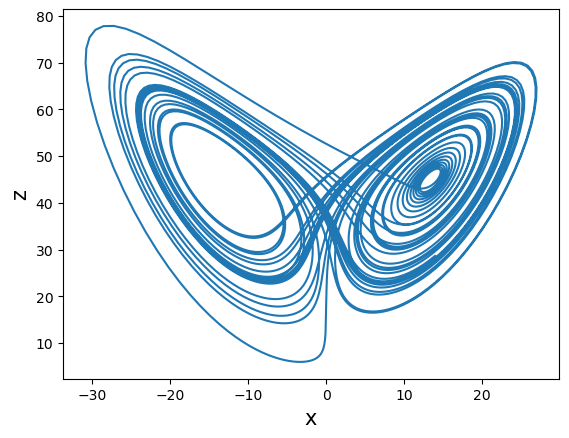

In [35]:
#attractor by using all the data
#plt.scatter(x_1, x_2, marker='.')

#attractor by using a single packet of data
samp = 0
plt.plot(xx[samp], zz[samp])

plt.ylabel('z', size=15)
plt.xlabel('x', size=15)
plt.show()

In [72]:
def rosenstein(x, dt, m, J, L):
    
    N = len(x)
    #attractor reconstruction
    M = N - (m - 1) * J
    print(f'M={M}  for N={N}, J={J} and m={m}')
    X = np.zeros((M, m))
    for i in range(M):
        for k in range(m):
            X[i][k] = x[i + J * k]
            
    #orbital mean period
    ps = np.abs(np.fft.fft(x))**2
    freqs = np.fft.fftfreq(N, dt)
    mean_f = np.average(freqs[1:N//2], weights=ps[1:N//2])
    mean_T = 1/mean_f
    
    #computation of the nearest neighbors for each point
    nbrs = NearestNeighbors(n_neighbors=(int(mean_T/dt)), algorithm='brute').fit(X)
    distances, indices = nbrs.kneighbors(X)
    
    #list of the distance between nearest neighbors as time goes on until L*dt
    distances_list = []

    for j in range(M - L):  
        #check constraint temporale
        r = 1 #inizio a contare dal primo vicino

        while (np.abs(indices[j][0] - indices[j][r]) * dt) <= mean_T:
            r += 1
        k = indices[j][r]

        #check sull'evoluzione temporale della distanza d_j
        if (k + L) <= (M - 1):
            d_j = np.zeros(L + 1)
            for i in range(L + 1):
                d_j[i] = np.linalg.norm(X[j + i] - X[k + i])

            distances_list.append(d_j)
    return distances_list


def linear_fit(x, m, q):
    return x * m + q


def mean_divergence(a, L_n):
    
    d = np.zeros(L_n + 1)
    for r in range(len(a)):
        d = d + a[r]
    d = d / len(a)
    return d

def exp_lyapunov_estimation(start_n, stop_n, dt, div_array):
    # div_array: array of average divergence as time goes on
    x_data = np.linspace(start_n, stop_n, (stop_n - start_n + 1))*dt
    y_data = np.log(div_array[start_n : (stop_n + 1)])
    popt, pcov = curve_fit(linear_fit, x_data, y_data)
    return popt[0]

In [73]:
#dt=0.01, N=5000
a_1 = np.ndarray((3, 5000))

#dt=0.01, N=1000
a_2 = np.ndarray((3, 1000))

#dt=0.05, N=1000
a_3 = np.ndarray((3, 1000))

for v in range(3):
    for u in range(5000):
        a_1[v][u] = xx[v][u]
        if u<1000:
            a_3[v][u] = xx[v][u*5]
            a_2[v][u] = xx[v][u]

In [75]:
xx = a_1
dt  = 0.01 
J = 12

In [83]:
xx = a_2
dt = 0.01
J = 10

In [89]:
xx = a_3
dt = 0.05
J = 3

In [99]:
%%time
#SET m and J(the lag)
m = 3
#J = 11

packet = 0

L = 2.5

#conversion of L to number of iterations
L_n = int(L / dt)

distances_list = rosenstein(xx[packet], dt, m, J, L_n)

print(f'evoluzione temporale di {L}')
print("punti ricostruiti per cui è possibile fare l'evoluzione temporale", len(distances_list))

M=994  for N=1000, J=3 and m=3
evoluzione temporale di 2
punti ricostruiti per cui è possibile fare l'evoluzione temporale 918
Wall time: 295 ms


In [80]:
nino_y = mean_divergence(distances_list, L_n)
nino_x = np.linspace(0, L_n, L_n + 1)*dt

In [85]:
chicco_y = mean_divergence(distances_list, L_n)
chicco_x = np.linspace(0, L_n, L_n + 1)*dt

In [91]:
pippo_y = mean_divergence(distances_list, L_n)
pippo_x = np.linspace(0, L_n, L_n + 1)*dt

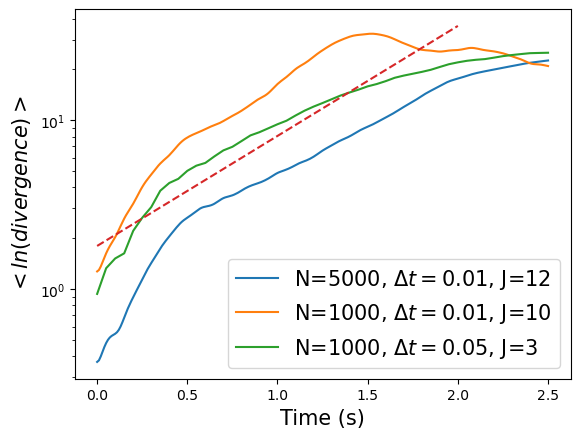

In [102]:
#plt.semilogy(np.linspace(0, L_n, L_n + 1)*dt, mean_divergence(distances_list, L_n))
plt.semilogy(nino_x, nino_y, label=f'N={5000}, $\Delta t ={0.01}$, J=12')
plt.semilogy(chicco_x, chicco_y, label=f'N={1000}, $\Delta t ={0.01}$, J=10')
plt.semilogy(pippo_x, pippo_y, label=f'N={1000}, $\Delta t ={0.05}$, J=3')

# WARNING: la costante moltiplicativa 0.5 ha valore arbitrario!
lambda_atteso = 1.5
y_ross = 1.8 * np.exp(np.linspace(0, L_n, L_n + 1) * dt * lambda_atteso) 
plt.semilogy(np.linspace(0, L_n, L_n + 1)*dt, y_ross, linestyle='--')
#cursore verticale
#plt.plot(np.ones(100)*1, np.logspace(0,0.5, 100)) 
#plt.grid()
plt.xlabel('Time (s)', size=15)
plt.ylabel(f'$< ln(divergence) >$', size=15)
plt.legend(fontsize=15)
#plt.title(f'N_{N}_dt_{dt}_m_{m}_J_{J}_packet_{packet}_L_{L}')
plt.savefig(f'varying_sampling_packet_.pdf')
plt.show()

In [239]:
# linear region as time interval in seconds
start_p = 0.65
stop_p = 0.82
# conversion to iterations
start_n = int(start_p / dt)
stop_n = int(stop_p / dt)
# computation
exp_lyapunov_estimation(start_n, stop_n, dt, mean_divergence(distances_list, L_n))

1.4504413716368085

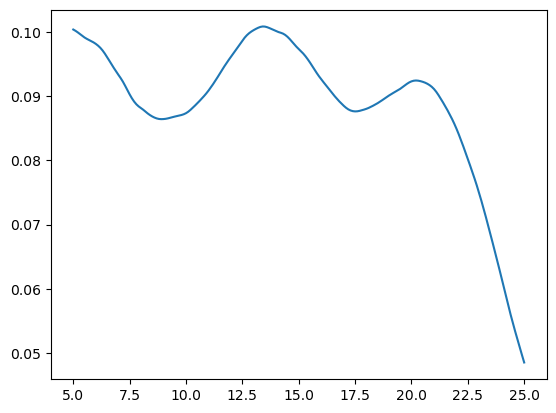

In [102]:
# FINAL IMPLEMENTATION
n_repeatition = xx.shape[0]
N = xx.shape[1]
start_t = 5
stop_t =  25
derivative_t = 3.5

#conversion of t_max to number of iterations
L_n = int(L / dt)
start_n = int(start_t / dt)
stop_n = int(stop_t / dt)
derivative_points = int( derivative_t/ dt)

listone = []

for i in range(start_n, stop_n+1):
    listone.append(
        exp_lyapunov_estimation((i - derivative_points), (i + derivative_points), dt, mean_divergence(distances_list, L_n))
    )
    
    
plt.plot(np.arange(start_n, stop_n+1)*dt, listone)
plt.show()

In [84]:
%%time
# FINAL IMPLEMENTATION
#n_repeatition = xx.shape[0]
N = xx.shape[1]
n_repeatition = 3
m = 3
J = 9
dt = 0.01
L=3
# time in seconds
start_t = 0.5
stop_t =  2.5

derivative_points = 25

# conversion from seconds to number of iterations
L_n = int(L / dt)
start_n = int(start_t / dt)
stop_n = int(stop_t / dt)



final_plot = []
for j in range(n_repeatition):
    print(f'data packet {j+1}')
    a = rosenstein(xx[j], dt, m, J, L_n)
    b = []
    for i in range(start_n, stop_n+1):
        b.append(
            exp_lyapunov_estimation((i - derivative_points), (i + derivative_points), dt, mean_divergence(a, L_n))
        )
    final_plot.append(b)


data packet 1
M=4982  for N=5000, J=9 and m=3
data packet 2
M=4982  for N=5000, J=9 and m=3
data packet 3
M=4982  for N=5000, J=9 and m=3
Wall time: 26.9 s


In [76]:
# vettore per memorizzare i range di plateau per ogni dataset
u = np.ndarray((n_repeatition,2))
# se lo metto nel blocco sotto ogni volta che faccio un run perdo i valori già memorizzati...

In [85]:
acab = 3
pluto = np.zeros(len(final_plot[0]))
for l in range(acab): 
    pluto += np.array(final_plot[l])
pluto = pluto/acab

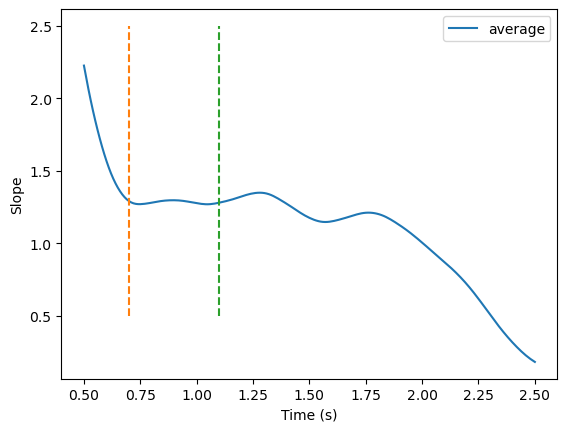

In [86]:
# multiple plot
# plt.plot(np.arange(start_n, stop_n+1)*dt, np.array(final_plot[0]), label='data packet 1')  
# plt.plot(np.arange(start_n, stop_n+1)*dt, np.array(final_plot[1]), label='data packet 2')  
# plt.plot(np.arange(start_n, stop_n+1)*dt, np.array(final_plot[2]), label='data packet 3') 
plt.plot(np.arange(start_n, stop_n+1)*dt, pluto, label='average') 


# trick
# plt.plot((np.arange(start_n, stop_n+1)*dt)[u_n[ref_][0]:u_n[ref_][1]],
#          np.array(final_plot[ref_])[u_n[ref_][0]:u_n[ref_][1]],
#          label=f'data packet {ref_ + 1}'
#         ) 


ref_ = 2
# u[ref_][0] = 1.55
# u[ref_][1] = 1.7

#plt.plot((np.arange(start_n, stop_n+1)*dt), np.array(final_plot[ref_]), label=f'data packet {ref_ + 1}') 
#cursori verticali per la selezione dei plateau
# plt.plot(np.ones(50)*u[ref_][0], np.linspace(0.5,2.5,50), linestyle='--')
# plt.plot(np.ones(50)*u[ref_][1], np.linspace(0.5,2.5,50), linestyle='--')
# #cursore orizzontale
# plt.plot(np.linspace(0.4,1.5,50), np.ones(50)*1.55, linestyle='--')
plt.plot(np.ones(50)*0.7, np.linspace(0.5,2.5,50), linestyle='--')
plt.plot(np.ones(50)*1.1, np.linspace(0.5,2.5,50), linestyle='--')

plt.legend()
plt.ylabel('Slope')
plt.xlabel('Time (s)')
plt.savefig('25.pdf')
plt.show()

In [176]:
u_n = u/dt - start_n
u_n = u_n.astype(int)
# non stavo considerando l'ultimo punto del plateau
u_n.T[1] = u_n.T[1] + 1

method 1 to compute lambda with an error

In [177]:
max_u = 0
min_u = 3
av_lambda = 0

for k in range(n_repeatition):
    q = np.array(final_plot[k])[u_n[k][0]:u_n[k][1]]
    av_lambda = av_lambda + q.mean()
    print(q.mean())
    if q.max() > max_u:
        max_u = q.max()
    if q.min() < min_u:
        min_u = q.min()

print(f"{av_lambda/n_repeatition}+-{(max_u - min_u)/2}")

1.2841969827506041
1.4804119970002452
1.4103906194992741
1.3916665330833744+-0.13177608086268544


method 2 to compute lambda with an error

In [199]:
g_n = u/dt
g_n = g_n.astype(int)

In [203]:
%%time
b=0
for j in range(n_repeatition):
    print(f'data packet {j+1}')
    a = rosenstein(xx[j], dt, m, J, L_n)
    start_n = g_n[j][0]
    stop_n = g_n[j][1]
    c = exp_lyapunov_estimation(start_n, stop_n, dt, mean_divergence(a, L_n))
    print(c)
    b += c
print(f'{b/n_repeatition}')

data packet 1
M=4976  for N=5000, J=12 and m=3
1.250058707904679
data packet 2
M=4976  for N=5000, J=12 and m=3
1.4880914987260911
data packet 3
M=4976  for N=5000, J=12 and m=3
1.4411607517205438
1.3931036527837712
Wall time: 24.7 s


## effects of parameters

In [52]:
packet = 0
dt = 0.01
L = 3
#conversion of L to number of iterations
L_n = int(L / dt)

# optimal parameters
m = 3
J = 11

# range of analysis
m_list = [1, 3, 5, 7, 9]
J_list = [2, 8, 14, 20]

### effects of embedding dimension

In [ ]:
%%time

supp_m = []
for k in m_list:
    
    supp_m.append(rosenstein(xx[packet], dt, k, J, L_n))

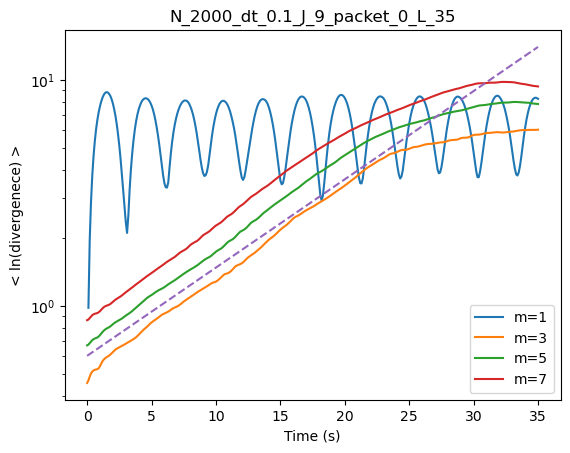

In [46]:
# multiple plot for J

plt.semilogy((np.linspace(0, L_n, L_n + 1)*dt)[1:], mean_divergence(supp_m[0], L_n)[1:], label=f'm={m_list[0]}')
plt.semilogy(np.linspace(0, L_n, L_n + 1)*dt, mean_divergence(supp_m[1], L_n), label=f'm={m_list[1]}')
plt.semilogy(np.linspace(0, L_n, L_n + 1)*dt, mean_divergence(supp_m[2], L_n), label=f'm={m_list[2]}')
plt.semilogy(np.linspace(0, L_n, L_n + 1)*dt, mean_divergence(supp_m[3], L_n), label=f'm={m_list[3]}')


# WARNING: la costante moltiplicativa 0.5 ha valore arbitrario!
lambda_atteso = 0.09
y_ross = 0.6 * np.exp(np.linspace(0, L_n, L_n + 1) * dt * lambda_atteso) 
plt.semilogy(np.linspace(0, L_n, L_n + 1)*dt, y_ross, linestyle='--')
plt.xlabel('Time (s)')
plt.ylabel('< ln(divergenece) >')
plt.legend()
plt.title(f'N_{N}_dt_{dt}_J_{J}_packet_{packet}_L_{L}')
#plt.savefig(f'N_{N}_dt_{dt}_J_{J}_packet_{packet}_L_{L}.pdf')
plt.show()

### effects of reconstruction delay 

In [ ]:
%%time

supp_J = []
for k in J_list:
    
    supp_J.append(rosenstein(xx[packet], dt, m, k, L_n))

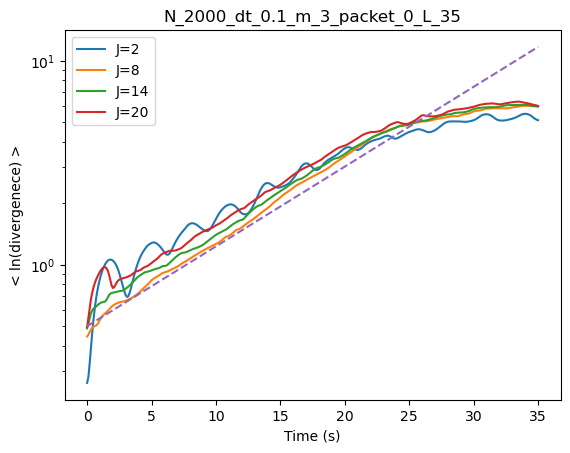

Wall time: 272 ms


In [47]:
%%time
# multiple plot for J

plt.semilogy((np.linspace(0, L_n, L_n + 1)*dt), mean_divergence(supp_J[0], L_n), label=f'J={J_list[0]}')
plt.semilogy(np.linspace(0, L_n, L_n + 1)*dt, mean_divergence(supp_J[1], L_n), label=f'J={J_list[1]}')
plt.semilogy(np.linspace(0, L_n, L_n + 1)*dt, mean_divergence(supp_J[2], L_n), label=f'J={J_list[2]}')
plt.semilogy(np.linspace(0, L_n, L_n + 1)*dt, mean_divergence(supp_J[3], L_n), label=f'J={J_list[3]}')


# WARNING: la costante moltiplicativa 0.5 ha valore arbitrario!
lambda_atteso = 0.09
y_ross = 0.5 * np.exp(np.linspace(0, L_n, L_n + 1) * dt * lambda_atteso) 
plt.semilogy(np.linspace(0, L_n, L_n + 1)*dt, y_ross, linestyle='--')
plt.xlabel('Time (s)')
plt.ylabel('< ln(divergenece) >')
plt.legend()
plt.title(f'N_{N}_dt_{dt}_m_{m}_packet_{packet}_L_{L}')
#plt.savefig(f'.pdf')
plt.show()